**Домашнее задание к уроку 7.**

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.

2. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.

3. Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы.

 4*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).



---



In [152]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math

Загрузим один из "игрушечных" датасетов из sklearn.

In [153]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [154]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

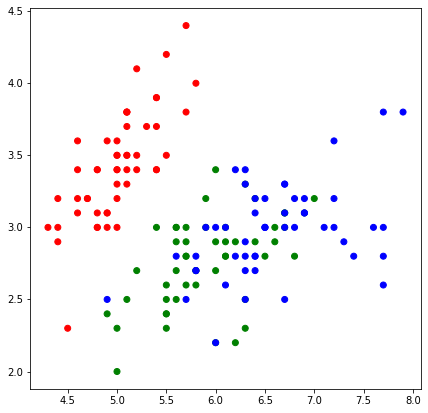

In [155]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [156]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

Реализуем различные для последующего сравнения алгоритмы вычисления весов

In [157]:
def weight_on_number_nn_1(i, q = 0.5):
    return q**i

In [158]:
def weight_on_number_nn_2(i):
    if i == 0:
        return 1
    else:        
        return 1 / i

In [159]:
def weight_on_number_nn_3(i, k):
    if k == 0:
        return 1
    elif k + 1 - i == 0:
        return 1 / k
    else:        
        return (k + 1 - i) / k

In [160]:
def weight_on_distance_4(d, q = 0.5):
    return q**d

In [161]:
def weight_on_number_nn_5(i):
    a = 1
    b = 1.5
    return 1 / (i + a)**b

In [162]:
def weight_on_distance_6(d):
    a = 1
    b = 1.5
    return 1 / (d + a)**b

In [163]:
def get_weight(weights_algorithm, k, distance, i, q = 0.5):
    if weights_algorithm == 0:
        return 1
    if weights_algorithm == 1:
        return weight_on_number_nn_1(i, q)
    elif weights_algorithm == 2:
        return weight_on_number_nn_2(i)
    elif weights_algorithm == 3:
        return weight_on_number_nn_3(i, k)
    elif weights_algorithm == 4:
        return weight_on_distance_4(distance, q)
    elif weights_algorithm == 5:
        return weight_on_number_nn_5(i)
    elif weights_algorithm == 6:
        return weight_on_distance_6(distance)

In [164]:
# Parzen Windows
# # set.seed(1)                                                     #Used for reproducibility
# # data = c(rnorm(100,-10,1),rnorm(100,10,1))                      #Two Normals mixed
# #` True
# #Normal Density
# def phi(x):
#     return exp(-.5 * x ^ 2) / np.sqrt(2 * math.pi)

# #True Density
# def tpdf(x):
#     return phi(x + 10) / 2 + phi(x - 10) / 2

# #` Kernel
# #Bandwidth estimated by Silverman's Rule of Thumb
# def h(data):
#     return np.std(data) * (4 / 3 / len(data)) ^ (1 / 5)

# #Kernel Density
# def Kernel2(x):
#     return mean(phi((x - data) / h(x)) / h(x))

# #Elementwise application
# def kpdf(x):
#     return sapply(x,Kernel2)


# # plot(x,tpdf(x))
# # plot(x,kpdf(x))
# #` Plot
# x=[x.totypes(float64) for x in range(-25,25,1000)]
# plt.plot(x,tpdf(x),type="l",ylim=c(0,0.23),col="red")
# # par(new=T)
# plt.plot(x,kpdf(x),type="l",ylim=c(0,0.23),xlab="",ylab="",axes=F)

Реализуем алгоритм поиска k ближайших соседей.

In [165]:
def knn(x_train, y_train, x_test, k, weight = 0, q = 0.5):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            # print('distance:', distance, get_weight(weight, k, distance, i, q))
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance * get_weight(weight, k, distance, i, q), y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [166]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [209]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

Проверим работу алгоритма при различных k



---



In [168]:
K = [1, 3, 5, 10]
WEIGHTS = [0, 1, 2, 3, 4, 5, 6]
QS = [0.1, 0.5, 0.9]

Точность алгоритма при k = 1 / weight_algorithm = 0 / q = 0.1: 0.667
Точность алгоритма при k = 1 / weight_algorithm = 1 / q = 0.1: 0.467
Точность алгоритма при k = 1 / weight_algorithm = 1 / q = 0.5: 0.600
Точность алгоритма при k = 1 / weight_algorithm = 1 / q = 0.9: 0.767
Точность алгоритма при k = 1 / weight_algorithm = 2 / q = 0.1: 0.733
Точность алгоритма при k = 1 / weight_algorithm = 3 / q = 0.1: 0.000
Точность алгоритма при k = 1 / weight_algorithm = 4 / q = 0.1: 0.267
Точность алгоритма при k = 1 / weight_algorithm = 4 / q = 0.5: 0.667
Точность алгоритма при k = 1 / weight_algorithm = 4 / q = 0.9: 0.667
Точность алгоритма при k = 1 / weight_algorithm = 5 / q = 0.1: 0.767
Точность алгоритма при k = 1 / weight_algorithm = 6 / q = 0.1: 0.667


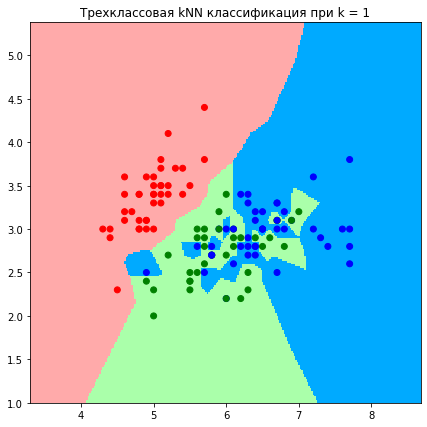

Точность алгоритма при k = 3 / weight_algorithm = 0 / q = 0.1: 0.733
Точность алгоритма при k = 3 / weight_algorithm = 1 / q = 0.1: 0.367
Точность алгоритма при k = 3 / weight_algorithm = 1 / q = 0.5: 0.367
Точность алгоритма при k = 3 / weight_algorithm = 1 / q = 0.9: 0.733
Точность алгоритма при k = 3 / weight_algorithm = 2 / q = 0.1: 0.667
Точность алгоритма при k = 3 / weight_algorithm = 3 / q = 0.1: 0.000
Точность алгоритма при k = 3 / weight_algorithm = 4 / q = 0.1: 0.033
Точность алгоритма при k = 3 / weight_algorithm = 4 / q = 0.5: 0.700
Точность алгоритма при k = 3 / weight_algorithm = 4 / q = 0.9: 0.733
Точность алгоритма при k = 3 / weight_algorithm = 5 / q = 0.1: 0.700
Точность алгоритма при k = 3 / weight_algorithm = 6 / q = 0.1: 0.733


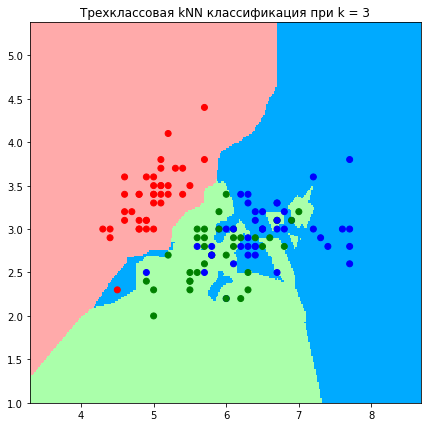

Точность алгоритма при k = 5 / weight_algorithm = 0 / q = 0.1: 0.867
Точность алгоритма при k = 5 / weight_algorithm = 1 / q = 0.1: 0.200
Точность алгоритма при k = 5 / weight_algorithm = 1 / q = 0.5: 0.200
Точность алгоритма при k = 5 / weight_algorithm = 1 / q = 0.9: 0.600
Точность алгоритма при k = 5 / weight_algorithm = 2 / q = 0.1: 0.667
Точность алгоритма при k = 5 / weight_algorithm = 3 / q = 0.1: 0.000
Точность алгоритма при k = 5 / weight_algorithm = 4 / q = 0.1: 0.000
Точность алгоритма при k = 5 / weight_algorithm = 4 / q = 0.5: 0.833
Точность алгоритма при k = 5 / weight_algorithm = 4 / q = 0.9: 0.867
Точность алгоритма при k = 5 / weight_algorithm = 5 / q = 0.1: 0.667
Точность алгоритма при k = 5 / weight_algorithm = 6 / q = 0.1: 0.867


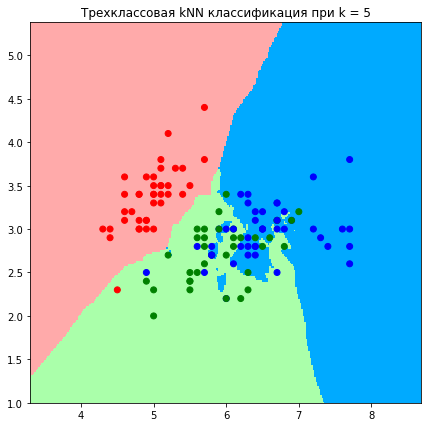

Точность алгоритма при k = 10 / weight_algorithm = 0 / q = 0.1: 0.833
Точность алгоритма при k = 10 / weight_algorithm = 1 / q = 0.1: 0.200
Точность алгоритма при k = 10 / weight_algorithm = 1 / q = 0.5: 0.200
Точность алгоритма при k = 10 / weight_algorithm = 1 / q = 0.9: 0.433
Точность алгоритма при k = 10 / weight_algorithm = 2 / q = 0.1: 0.833
Точность алгоритма при k = 10 / weight_algorithm = 3 / q = 0.1: 0.000
Точность алгоритма при k = 10 / weight_algorithm = 4 / q = 0.1: 0.000
Точность алгоритма при k = 10 / weight_algorithm = 4 / q = 0.5: 0.800
Точность алгоритма при k = 10 / weight_algorithm = 4 / q = 0.9: 0.833
Точность алгоритма при k = 10 / weight_algorithm = 5 / q = 0.1: 0.800
Точность алгоритма при k = 10 / weight_algorithm = 6 / q = 0.1: 0.833


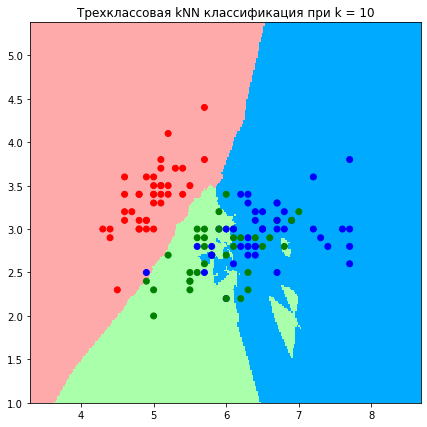

CPU times: user 3min 58s, sys: 118 ms, total: 3min 58s
Wall time: 3min 58s


In [169]:
%%time

for k in K:

    for weight in WEIGHTS:

            for q in QS:

                y_pred = knn(X_train, y_train, X_test, k, weight, q)

                print(f'Точность алгоритма при k = {k} / weight_algorithm = {weight} / q = {q}: {accuracy(y_pred, y_test):.3f}')
                
                if weight != 1 and weight != 4:
                    break

    get_graph(X_train, y_train, k)

**Выводы.**

При увеличении k (количества "ближайших соседей") и подборе других параметров (алгоритмов расчета весов и q для 1-го и 4-го алгоритмов расчета весов) на основании графиков kNN-алгоритм в целом проявляет лучшее обучение (уходят островки "недообученности"). Что касается точности предсказаний, то механизм применения весов лишь в начальном случае доказал свою целесообразность при алгоритме расчета весов 2, в остальных случаях применения весов в лучшем случае достигло значения, так же как при алгоритме расчета весов 1, т.е. w=1.



---



Задание 4.


In [171]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

Изобразим точки на графике.

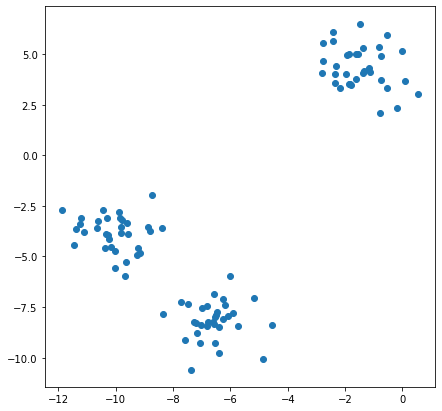

In [172]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [205]:
# среднее квадратичное внутрикластерное расстояние
def mean_squared_intracluster_distance_metrics(centroids, clusters):
    
    distance = 0
    # print('1._mean:len(clusters):',len(clusters))
    # print('2._mean:len(centroids):',len(centroids))
    if len(clusters) == len(centroids): 
        for cluster in clusters.keys() :
            # print('3._mean:cluster:',cluster)
            for k in range(len(centroids)):
                # print('4._mean:centroids[k]:',centroids[k])
                if k == cluster:
                    # print('5._mean:clusters[k]:',clusters[k])
                    for i in range(len(clusters[k])):
                        # print('6._mean:clusters[k][i]:',clusters[k][i])
                        for j in range(len(centroids[k])):
                            # print('7._mean:clusters[k][i][j]:',clusters[k][i][j])
                            # print('8._mean:centroids[k][j]:',centroids[k][j])
                            distance += np.square(clusters[k][i][j] - centroids[k][j])
    
    return distance

В качестве метрики расстояния будем использовать евклидово расстояние, функция для которого была написана ранее. В качестве центроидов выберем первые k элементов датасета. Реализуем основной цикл алгоритма.

In [187]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    # print('1.kmeans:classes:',len(classes),classes)
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    # print('2.kmeans:centroids:',len(centroids),centroids)
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # print('3.kmeans:x:',len(x),x)
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # print('3.kmeans:distances:',distances)

            # определим среднее квадратичное внутрикластерное расстояние
            # distance = mean_squared_intracluster_distance_metrics(x, x_train[i])

            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

Напишем функцию для визуализации кластеров

In [211]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b','#FFFFAA', '#AAFFFF','#00A0F0','#F0F0AA', '#A0F0F0','#0FAFF0','#FF3FA5']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [229]:
def get_plot(x, y, title, label, x_label, y_label):
    plt.figure(figsize=(15, 8))
    plt.title(title, fontsize=20)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, y, label=label)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [203]:
K = [1, 3, 5, 10]
ITERATIONS = [1, 3, 5, 10]

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 1 / max_iterations = 1 / msid = 8933.051


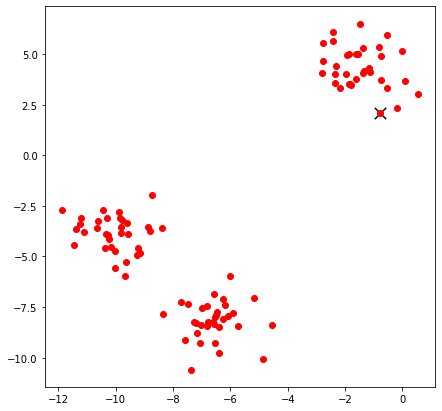

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 3 / max_iterations = 1 / msid = 944.604


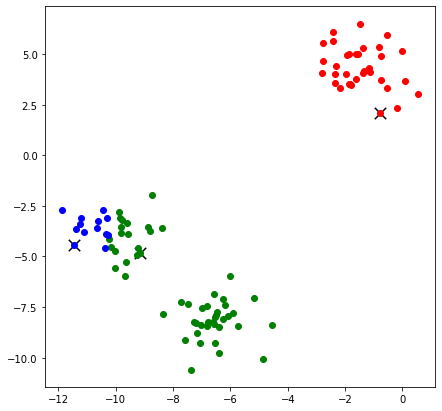

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 5 / max_iterations = 1 / msid = 452.382


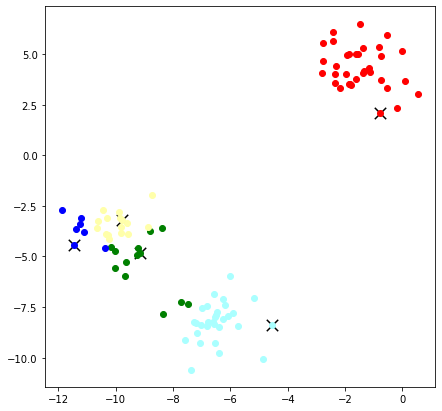

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 10 / max_iterations = 1 / msid = 100.577


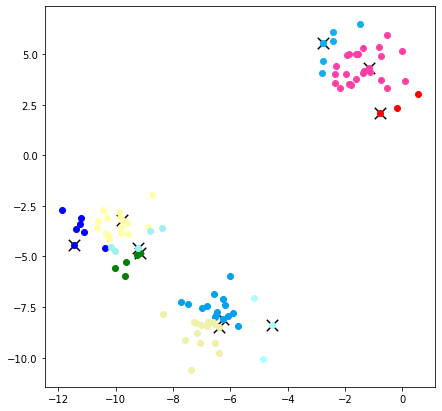

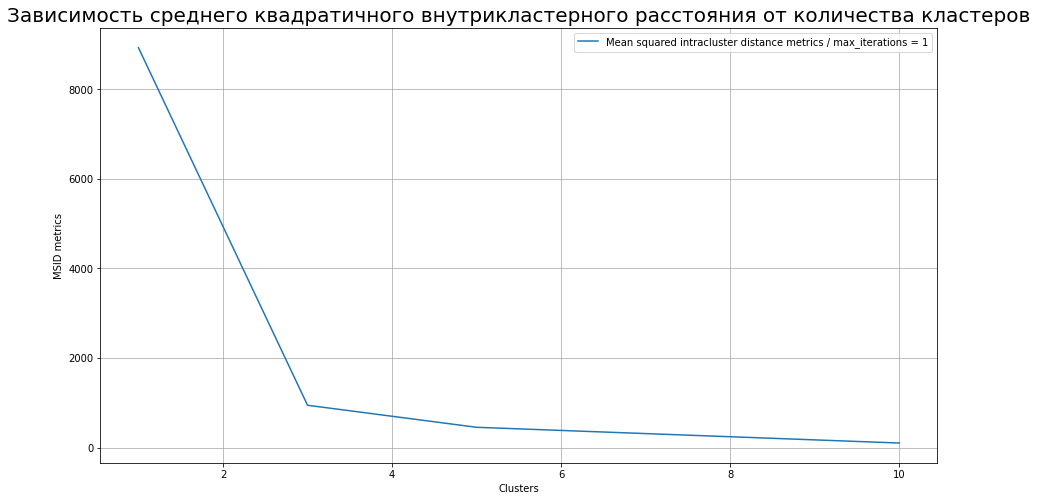

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 1 / max_iterations = 3 / msid = 8236.308


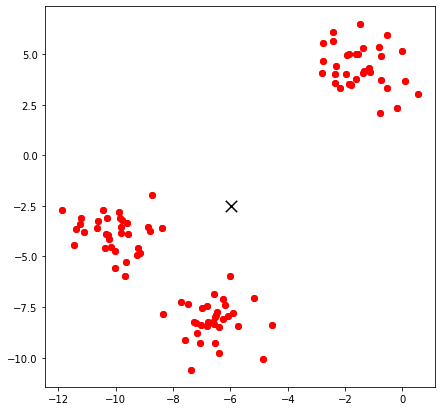

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 3 / max_iterations = 3 / msid = 904.462


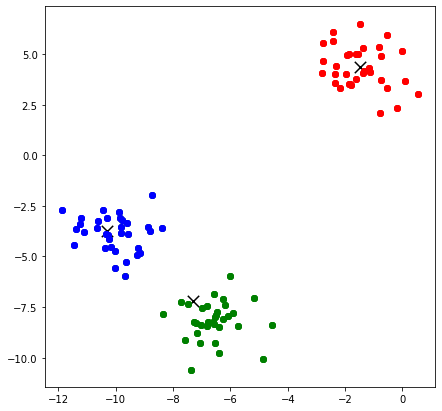

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 5 / max_iterations = 3 / msid = 407.128


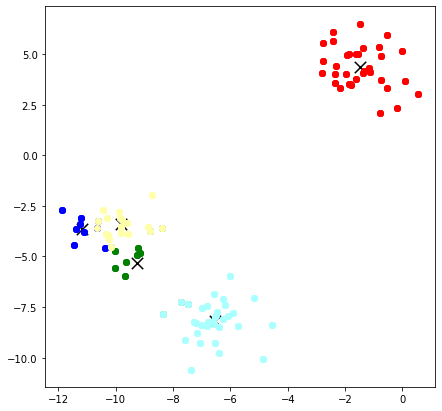

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 10 / max_iterations = 3 / msid = 211.669


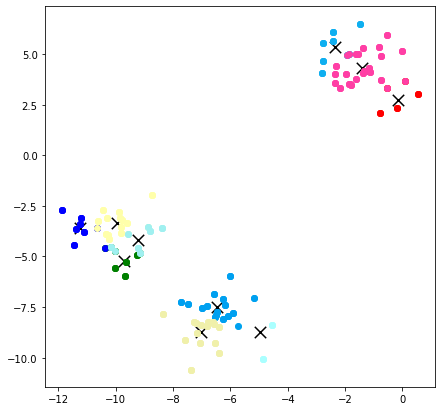

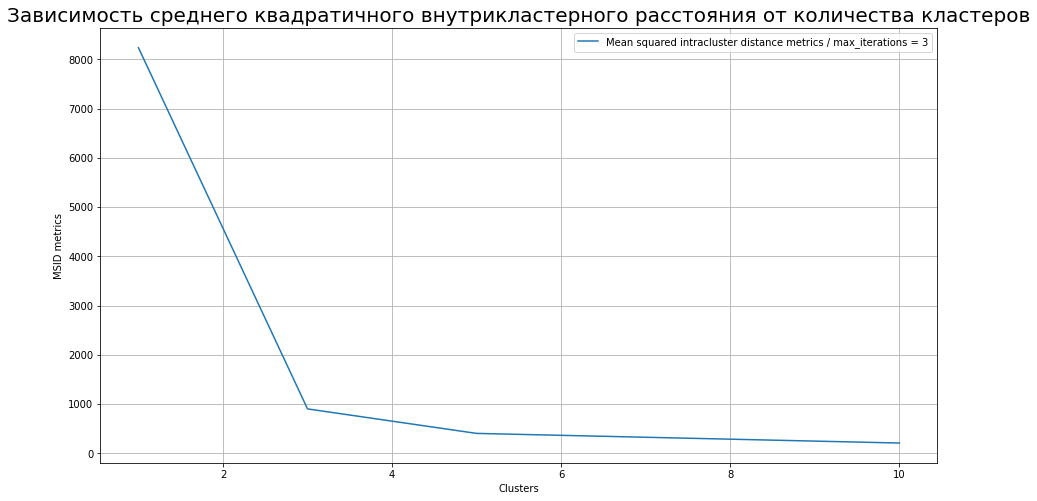

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 1 / max_iterations = 5 / msid = 8236.308


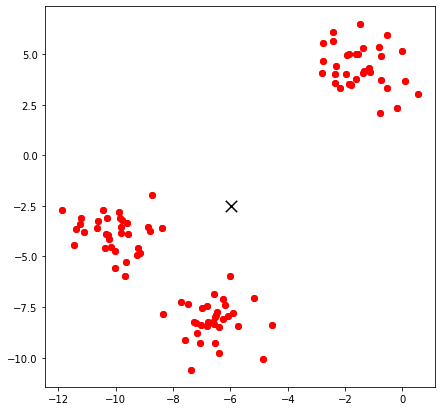

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 3 / max_iterations = 5 / msid = 1238.987


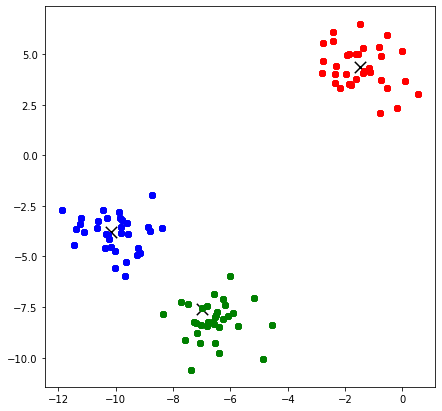

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 5 / max_iterations = 5 / msid = 663.698


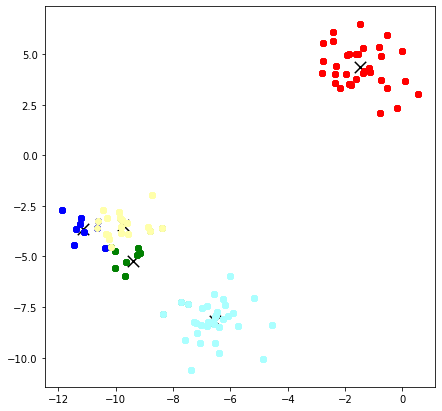

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 10 / max_iterations = 5 / msid = 344.246


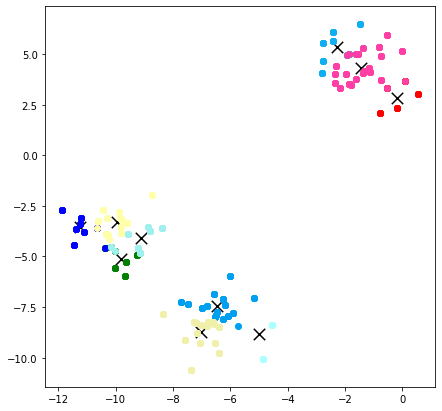

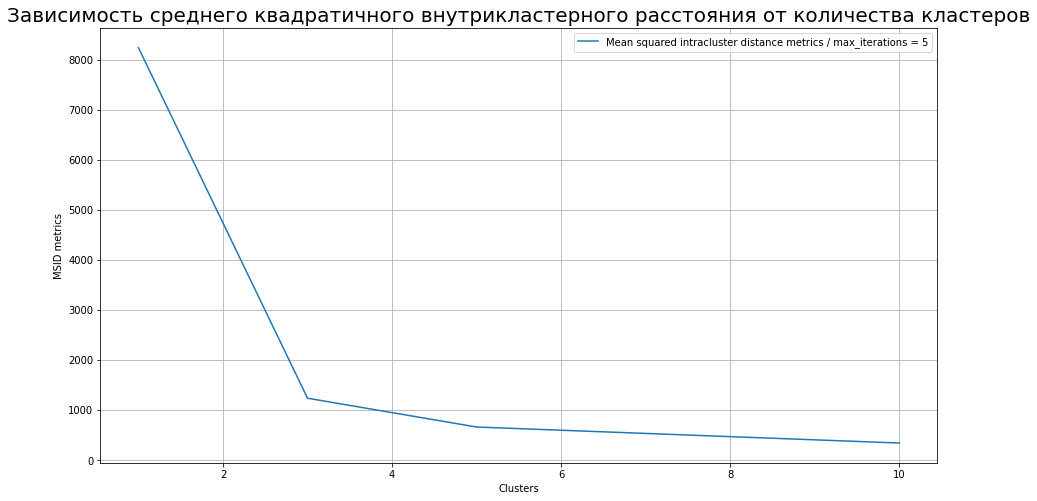

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 1 / max_iterations = 10 / msid = 8236.308


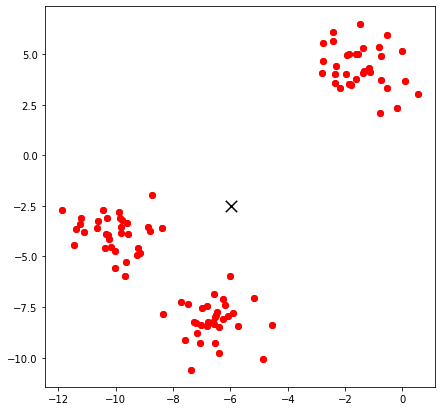

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 3 / max_iterations = 10 / msid = 2046.204


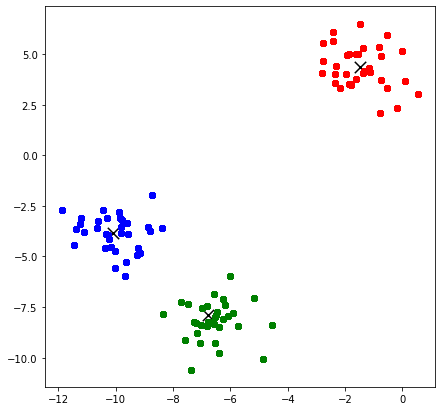

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 5 / max_iterations = 10 / msid = 1298.979


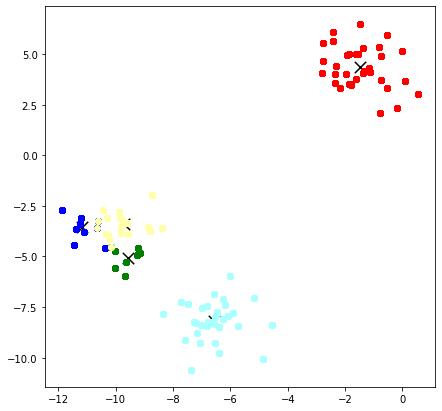

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 10 / max_iterations = 10 / msid = 668.998


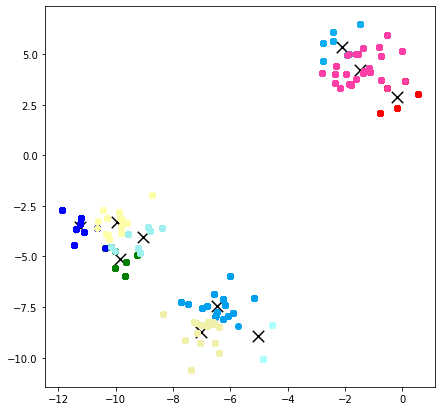

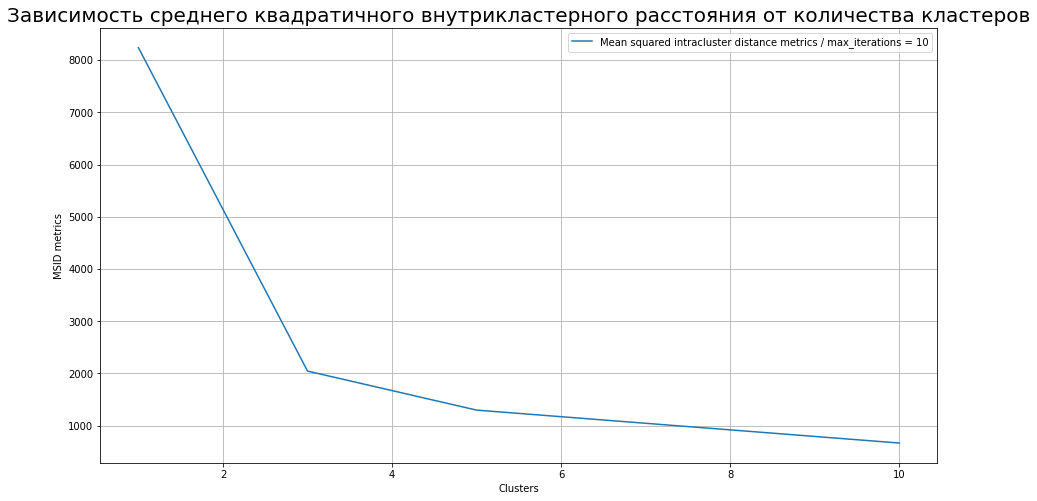

CPU times: user 25.8 s, sys: 79.1 ms, total: 25.9 s
Wall time: 25.9 s


In [230]:
%%time

for max_iterations in ITERATIONS:

    msid = []

    for i in range(len(K)):

        # и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
        min_distance = 1e-4

        # метод k-means
        centroids, clusters = kmeans(X, K[i], max_iterations, min_distance)

        # среднее квадратичное внутрикластерное расстояние
        msid.append(mean_squared_intracluster_distance_metrics(centroids, clusters))

        print(f'Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = {K[i]} / max_iterations = {max_iterations} / msid = {msid[i]:.3f}')

        # визуализация полученных кластеров
        visualize(centroids, clusters)

    # визуализация зависимости среднего квадратичного внутрикластерного расстояния от количества кластеров
    get_plot(K, msid, \
        'Зависимость среднего квадратичного внутрикластерного расстояния от количества кластеров', \
        f'Mean squared intracluster distance metrics / max_iterations = {max_iterations}', 'Clusters', 'MSID metrics')





---



**Выводы.**

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 1 / max_iterations = 1 / msid = 8933.051

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 1 / max_iterations = 3 / msid = 8236.308

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 1 / max_iterations = 5 / msid = 8236.308

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 1 / max_iterations = 10 / msid = 8236.308

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 3 / max_iterations = 1 / msid = 944.604

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 3 / max_iterations = 3 / msid = 904.462

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 3 / max_iterations = 5 / msid = 1238.987

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 3 / max_iterations = 10 / msid = 2046.204

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 5 / max_iterations = 1 / msid = 452.382

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 5 / max_iterations = 3 / msid = 407.128

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 5 / max_iterations = 5 / msid = 663.698

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 5 / max_iterations = 10 / msid = 1298.979

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 10 / max_iterations = 1 / msid = 100.577

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 10 / max_iterations = 3 / msid = 211.669

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 10 / max_iterations = 5 / msid = 344.246

Среднее квадратичное внутрикластерное расстояние k-means алгоритма при k = 10 / max_iterations = 10 / msid = 668.998

CPU times: user 337 ms, sys: 5 ms, total: 342 ms

Wall time: 344 ms

При построении зависимости среднего квадратичного внутрикластерного расстояния от количества кластеров прослеживается тенденция к уплотнению "ближайших соседей" внутри одного кластера. Согласно методу локтя (elbow method) по полученным графикам можно установить, что в разрезе итераций наиболее оптимальным является количество класторов равное 3-м.